In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import re
import random
from imageio import imread
from skimage.transform import resize


# Đọc folder

In [3]:
BASE_DIR = './drive/MyDrive/yalefaces'  # ← Đặt đúng đường dẫn tới folder yalefaces

# Lấy các folder có tên bắt đầu bằng 'person-' và theo sau là số (ví dụ: person-01)
person_folders = [name for name in os.listdir(BASE_DIR)
                  if os.path.isdir(os.path.join(BASE_DIR, name)) and re.match(r'^person-\d+$', name)]

# Sắp xếp theo số thứ tự người (person-01, person-02, ...)
person_folders = sorted(person_folders, key=lambda x: int(x.split('-')[1]))

print("Danh sách folder của 15 người:")
print(person_folders)

Danh sách folder của 15 người:
['person-1', 'person-2', 'person-3', 'person-4', 'person-5', 'person-6', 'person-7', 'person-8', 'person-9', 'person-10', 'person-11', 'person-12', 'person-13', 'person-14', 'person-15']


<ipython-input-4-5080c6150e2f>:6: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imread(os.path.join(BASE_DIR, person_folder, filename))


(243, 320)
(243, 320)
(243, 320)
(243, 320)
(243, 320)
(243, 320)
(243, 320)
(243, 320)
(243, 320)
(243, 320)


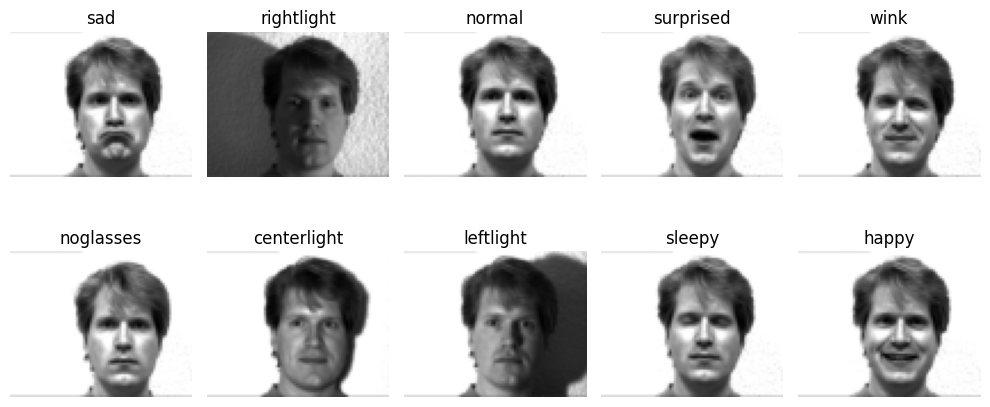

In [4]:
person_folder = random.choice(person_folders)

plt.figure(figsize=(10, 5))

for ith, filename in enumerate(os.listdir(os.path.join(BASE_DIR, person_folder))):
    image = imread(os.path.join(BASE_DIR, person_folder, filename))
    print(image.shape)

    if image.ndim == 3 and image.shape[0] == 1:
        image = image.squeeze(0)  # Chỉ gọi squeeze nếu cần
    image = resize(image, (64, 80), anti_aliasing=True)

    plt.subplot(2, 5, ith +1)
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.title(filename)

plt.tight_layout()
plt.show()

In [5]:
data = {}
for person_folder in person_folders:
  for filename in os.listdir(os.path.join(BASE_DIR, person_folder)):
    image = imread(os.path.join(BASE_DIR, person_folder, filename))
    image = resize(image, (1, 64, 80), anti_aliasing=True)
    if person_folder not in data:
      data[person_folder] = [image]
    else:
      data[person_folder].append(image)

for person in data:
  data[person] = np.concat(data[person], axis = 0).reshape(10, -1)

<ipython-input-5-44be1967e9d3>:4: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imread(os.path.join(BASE_DIR, person_folder, filename))


## Standardizing images

In [6]:
def standardizing(images):
  images = (images - images.mean()) / images.std()
  images = images.astype(np.float32)

  return images

## Principle Component Analysis

In [7]:
class PrincipleComponentAnalysis:
  def __init__(self, d_principle: int = 1):
    self.d_principle = d_principle

  def fit(self, X):
    cov = (X.T @ X)

    eigenvalues, eigenvectors = np.linalg.eig(cov)

    # change the sign of the maximum absoluted value to positive
    max_abs_idx = np.argmax(np.abs(eigenvectors), axis = 0)
    signs = np.sign(eigenvectors[max_abs_idx, range(eigenvectors.shape[0])])
    eigenvectors = eigenvectors * signs[np.newaxis,:]
    eigenvectors = eigenvectors.T # (num vector, dim)

    # rearrange the eigenvectors and eigenvalues
    eigen_pairs = [(np.abs(eigenvalues[i]), eigenvectors[i, :]) for i in range(eigenvectors.shape[0])]

    # sort the tuples
    eigen_pairs.sort(key = lambda pair : pair[0], reverse=True)

    # convert to ndarray
    eigenvalues = np.array([value for (value, _) in eigen_pairs])
    eigenvectors = np.array([vector for (_, vector) in eigen_pairs])

    # select the principle component
    self.principle_values = eigenvalues[:self.d_principle]
    self._W = eigenvectors[:self.d_principle]

  def transform(self, X):
    X_hat = self._W @ X

    return X_hat


## finding the principle components

In [8]:
PCA = PrincipleComponentAnalysis(d_principle=20)

In [9]:
images = []
for person in data:
  images.append(data[person])

images = np.concat(images, axis = 0)
images = standardizing(images)
images.shape

(150, 5120)

In [10]:
images.shape

(150, 5120)

In [11]:
PCA.fit(images)

In [12]:
PCA._W.shape

(20, 5120)

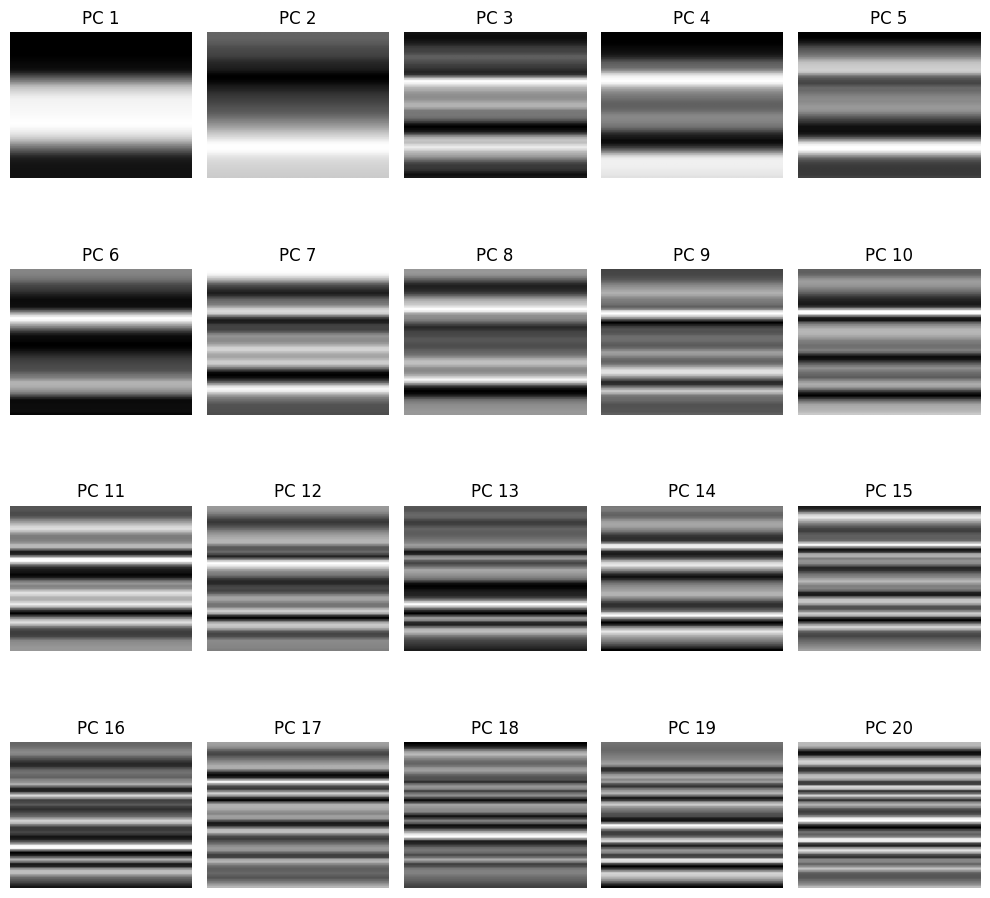

In [19]:
eigenfaces = PCA._W.real  # lấy phần thực
eigenfaces = eigenfaces.reshape(20, 64, 80)

plt.figure(figsize=(10, 10))
for ith, eigenface in enumerate(eigenfaces):
    plt.subplot(4, 5, ith + 1)
    plt.imshow(eigenface, cmap='gray')
    plt.axis('off')
    plt.title(f"PC {ith + 1}")

plt.tight_layout()
plt.show()


In [20]:
print(type(data['person-1']))  # Kiểm tra kiểu dữ liệu
print(data['person-1'].shape)  # Kiểm tra shape của ảnh


<class 'numpy.ndarray'>
(10, 5120)


## finding the mean face

In [21]:
mean_faces = {
    person: np.mean(images, axis = 0) for person, images in data.items()
}

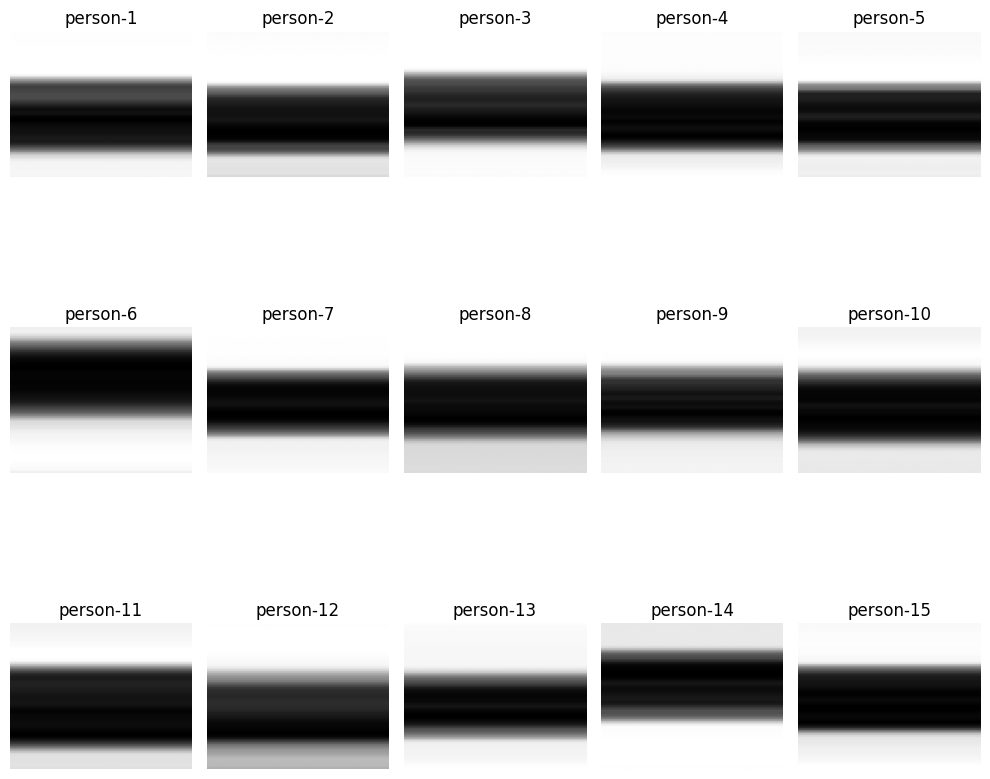

In [22]:
plt.figure(figsize = (10, 10))
for ith, person in enumerate(mean_faces):
  mean_face = mean_faces[person]
  mean_face = mean_face.reshape(64, 80)

  #display each image in a subplot
  plt.subplot(3, 5, ith + 1)
  plt.imshow(mean_face, cmap='gray')
  plt.axis('off')
  plt.title(person)

plt.tight_layout()
plt.show()

## project the mean face into principle space

In [23]:
projected_mean_faces = {}
for person in mean_faces:
  mean_face = mean_faces[person]
  projected_mean_faces[person] = PCA.transform(mean_face)

## loading the test data

In [24]:
labels = []
test_images = []

TEST_DIR = "./drive/MyDrive/yalefaces/test"
for filename in os.listdir(os.path.join(TEST_DIR)):
  person_name = filename.split(".")[0]
  labels.append(person_name)

  image = imread(os.path.join(TEST_DIR, filename))
  image = resize(image, (1, 64, 80), anti_aliasing=True)
  test_images.append(image)

<ipython-input-24-8be65b3ad8a3>:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imread(os.path.join(TEST_DIR, filename))


In [25]:
test_images = np.concat(test_images, axis=0)
test_images.shape

(15, 64, 80)

In [26]:
labels

['person-13',
 'person-7',
 'person-11',
 'person-3',
 'person-8',
 'person-12',
 'person-1',
 'person-15',
 'person-4',
 'person-6',
 'person-5',
 'person-2',
 'person-14',
 'person-10',
 'person-9']

In [27]:
def Euclide_distance(X, Y):
  assert X.shape == Y.shape, f"{X,__str__()} and {Y.__str__()} are miss-shaped"
  return (((X - Y)**2).sum())**0.5

In [28]:
predictions = {}
for label, image in zip(labels, test_images):
    image = image.reshape(-1)
    projected_face = PCA.transform(image)
    closet_distance = np.inf
    closet_person = None

    for person in projected_mean_faces:
        mean_face = projected_mean_faces[person]
        distance = Euclide_distance(mean_face, projected_face)

        if distance < closet_distance:
            closet_distance = distance
            closet_person = person

    predictions[label] = closet_person



In [29]:
# Tính accuracy
EMs = []
for label in predictions:
    # so sánh nhãn thật và dự đoán, đúng thì 1, sai thì 0
    EMs.append(int(predictions[label] == label))

In [30]:
print(f"Accuracy: {(np.mean(EMs) * 100):.2f}%")

Accuracy: 53.33%
